# Note
### probably need to modify hdf5_format.py in /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/keras/saving/, remove all .decode('utf-8') part

In [3]:
import numpy as np
from PIL import Image

img = Image.open('../YOLOv5-Classifier/linmao_classification/JPEGImages/8/nl_0431_1386 (1).jpg')
lr_img = np.array(img)

In [4]:
pwd

'/home/jupyter/image-super-resolution'

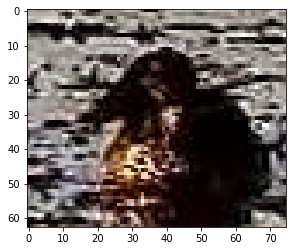

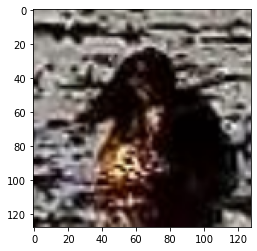

In [14]:
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('../YOLOv5-Classifier/linmao_classification/JPEGImages/8/nl_0431_1386 (1).jpg')
imgplot = plt.imshow(img)
plt.show()


img_size = 128

resized_arr = cv2.resize(img, (img_size, img_size)) # Reshaping images to preferred size
imgplot = plt.imshow(resized_arr)
plt.show()

In [15]:
img.shape

(63, 75, 3)

In [25]:
from ISR.models import RDN, RRDN, Cut_VGG19

name = ['psnr-small', 'psnr-large', 'noise-cancel', 'RRDN-gans']
rdn_small = RDN(weights='psnr-small') #psnr-large #psnr-small #noise-cancel
rdn_large = RDN(weights='psnr-large') #psnr-large #psnr-small #noise-cancel
rdn_noise = RDN(weights='noise-cancel') #psnr-large #psnr-small #noise-cancel
rrdn = RRDN(weights='gans')

models = [rdn_small, rdn_large, rdn_noise, rrdn]
results = []
for m in models:
    sr_img = m.predict(lr_img)
    results.append(sr_img)
    

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

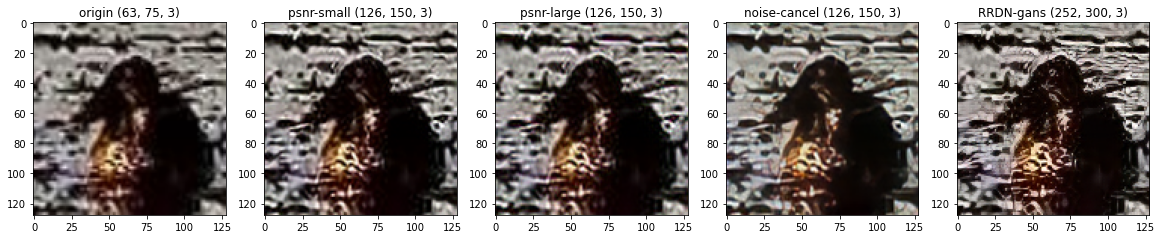

In [26]:
img_size = 128

plt.figure(figsize=(20, 5))
plt.subplot(1,5,1)
resized_arr = cv2.resize(img, (img_size, img_size)) # Reshaping images to preferred size
imgplot = plt.imshow(resized_arr)
plt.title(f'origin {img.shape}')

for idx, m_type in enumerate(name):
    plt.subplot(1,5,idx+2)
    sr_img = results[idx]
    resized_arr = cv2.resize(sr_img, (img_size, img_size)) # Reshaping images to preferred size
    imgplot = plt.imshow(resized_arr)
    plt.title(f'{m_type} {sr_img.shape}')
plt.show()

In [27]:
from ISR.models import RRDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19

lr_train_patch_size = 40
layers_to_extract = [5, 9]
scale = 2
hr_train_patch_size = lr_train_patch_size * scale

rrdn  = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale}, patch_size=lr_train_patch_size)
f_ext = Cut_VGG19(patch_size=hr_train_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_train_patch_size, kernel_size=3)

80150528/80134624 [==============================] - 2s 0us/step


In [ ]:
from ISR.train import Trainer
loss_weights = {
  'generator': 0.0,
  'feature_extractor': 0.0833,
  'discriminator': 0.01
}
losses = {
  'generator': 'mae',
  'feature_extractor': 'mse',
  'discriminator': 'binary_crossentropy'
}

log_dirs = {'logs': './logs', 'weights': './weights'}

learning_rate = {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}

flatness = {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}

trainer = Trainer(
    generator=rrdn,
    discriminator=discr,
    feature_extractor=f_ext,
    lr_train_dir='low_res/training/images',
    hr_train_dir='high_res/training/images',
    lr_valid_dir='low_res/validation/images',
    hr_valid_dir='high_res/validation/images',
    loss_weights=loss_weights,
    learning_rate=learning_rate,
    flatness=flatness,
    dataname='image_dataset',
    log_dirs=log_dirs,
    weights_generator=None,
    weights_discriminator=None,
    n_validation=40,
)

In [ ]:
trainer.train(
    epochs=80,
    steps_per_epoch=500,
    batch_size=16,
    monitored_metrics={'val_PSNR_Y': 'max'}
)